<a href="https://colab.research.google.com/github/yzeng1121/skin-lesion-image-detection/blob/main/ver2_efficient_net_v2_skin_cancer_diagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Importing the Dataset**

I will be using the open-source, pre-labeled, HAM10000 dataset taken from Kaggle, which was also used during the 2018 International Skin Imaging Collaboration (ISIC) challenge.

The dataset contains over 10,000 sample images of skin lesions classified into seven different categories of malignant (cancerous), benign (non-cancerous), and pre-cancerious types.

50% of the lesions were classified through histopathology and the other 50% were classified through follow-up appointments, expert consensus, or in-vivo confocal microscopy.

This database was chosen over ISIC 2017 because it's a smaller database allowing less time to train the CNN model.

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount = False)

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


### **Reading the Data**

Summarizing the columns:
*   the dx column represents the diagnosis of type of skin lesion
    *  mel - melanoma
    *  nv - melanocytic nevus (mole)
    *  bcc - basal cell carcinoma
    *  akiec - actinic keratosis / intraepithelial carcinoma
    *  bkl - benign keratosis
    *  df - dermatofibroma
    *  vasc - vascular lesion
*   the dx_type column represents how the diagnosis was made
    *  histo - histopathology
    *  follow_up - follow up over time
    *  consensus - multiple dermatologists approve
    *  confocal - in-vivo confocal microscopy imaging



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
import os

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

In [ ]:
metadata = pd.read_csv('/gdrive/MyDrive/em52/final_proj/data/HAM10000_metadata.csv')

dx_counts = metadata['dx'].value_counts().sort_index()
dx_type_counts = metadata['dx_type'].value_counts().sort_index()


print("\nDIAGNOSIS CLASSIFICATION STRUCTURE SUMMARY")
print("-" * 70)
print(f"{'Class Label' : <20} {'Count' : <15} {'Percentage' : <15}")
print("-" * 70)
for label, count in dx_counts.items():
    percentage = (count / dx_counts.sum() * 100)
    print(f"{label : <20} {count : <15} {percentage : <15.2f}%")
print("-" * 70)
print(f"{'Total' : <20} {dx_counts.sum() : <15}")
print()


print("\nDIAGNOSIS METHOD STRUCTURE SUMMARY")
print("-" * 35)
print(f"{'Method':<20} {'Count':<15}")
print("-" * 35)
for label, count in dx_type_counts.items():
    percentage = (count / dx_type_counts.sum() * 100)
    print(f"{label:<20} {count:<15}")
print("-" * 35)
print(f"{'Total':<20} {dx_type_counts.sum():<15}")




DIAGNOSIS CLASSIFICATION STRUCTURE SUMMARY
----------------------------------------------------------------------
Class Label          Count           Percentage     
----------------------------------------------------------------------
akiec                327             3.27           %
bcc                  514             5.13           %
bkl                  1099            10.97          %
df                   115             1.15           %
mel                  1113            11.11          %
nv                   6705            66.95          %
vasc                 142             1.42           %
----------------------------------------------------------------------
Total                10015          


DIAGNOSIS METHOD STRUCTURE SUMMARY
-----------------------------------
Method               Count          
-----------------------------------
confocal             69             
consensus            902            
follow_up            3704           
histo             

### **Loading the Image Data**



1.   identify the minority classes
2.   oversample the minority classes to balance out the overall database





In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
import os

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

In [ ]:
part_1_dir = '/gdrive/MyDrive/em52/final_proj/data/HAM10000_images_part_1'
part_2_dir = '/gdrive/MyDrive/em52/final_proj/data/HAM10000_images_part_2'

def get_image_path(image_id):
  path1 = os.path.join(part_1_dir, f"{image_id}.jpg")
  path2 = os.path.join(part_2_dir, f"{image_id}.jpg")

  return path1 if os.path.exists(path1) else path2

metadata['path'] = metadata['image_id'].apply(get_image_path)

label_map = {label: i for i, label in enumerate(sorted(metadata['dx'].unique()))}
print(f"Label map: {label_map}")

metadata['label_index'] = metadata['dx'].map(label_map)

def load_images(df, target_size = (224, 224)):
  images = []

  for path in df['path']:
    img = Image.open(path).convert('RGB')
    img = img.resize(target_size)
    img_array = np.array(img)
    images.append(img_array)

  return np.array(images)

Label map: {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [ ]:
from sklearn.utils import resample

In [ ]:
max_dx_count = dx_counts.max()

balanced_dfs = []

for class_label in metadata['dx'].unique():
    class_df = metadata[metadata['dx'] == class_label]

    if len(class_df) < max_dx_count:
        oversampled_df = resample(
            class_df,
            replace = True,
            n_samples = max_dx_count,
            random_state = 42
        )
        balanced_dfs.append(oversampled_df)
    else:
        balanced_dfs.append(class_df)

In [ ]:
balanced_metadata = pd.concat(balanced_dfs, ignore_index = True)
balanced_metadata = balanced_metadata.sample(frac = 1, random_state = 42).reset_index(drop = True)
balanced_metadata['path'] = balanced_metadata['image_id'].apply(get_image_path)
balanced_metadata['label_index'] = balanced_metadata['dx'].map(label_map)

balanced_counts = balanced_metadata['dx'].value_counts()

for label, count in balanced_counts.items():
    print(f"{label}: {count} samples ({count / len(balanced_metadata) * 100:.2f}%)")

mel: 6705 samples (14.29%)
bcc: 6705 samples (14.29%)
nv: 6705 samples (14.29%)
vasc: 6705 samples (14.29%)
akiec: 6705 samples (14.29%)
df: 6705 samples (14.29%)
bkl: 6705 samples (14.29%)


In [ ]:
balanced_images = load_images(balanced_metadata)
balanced_labels = balanced_metadata['label_index'].values

### **Building & Training the CNN Model**

1. split the annotated data into 15% testing, 15% validation, & 70% training
2. normalize & augment the data set
3. set up & configure the layers of the model
4. compile the model
5. set up callbacks to prevent overfitting/learning when model stops improving

In [ ]:
x_temp, x_test, y_temp, y_test = train_test_split(
    balanced_images,
    balanced_labels,
    test_size = 0.15,
    stratify = balanced_labels,
    random_state=42
)

x_train, x_val, y_train, y_val = train_test_split(
    x_temp,
    y_temp,
    test_size = 0.176,
    stratify = y_temp,
    random_state = 42
)

unique, counts = np.unique(y_train, return_counts = True)

for label_idx, count in zip(unique, counts):
  label_name = [k for k, v in label_map.items() if v == label_idx][0]

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_test = x_test.astype('float32')

y_train_cat = to_categorical(y_train, num_classes = len(label_map))
y_val_cat = to_categorical(y_val, num_classes = len(label_map))
y_test_cat = to_categorical(y_test, num_classes = len(label_map))

In [ ]:
train_data_gen = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    zoom_range = 0.15,
    brightness_range = [0.8, 1.2],
    fill_mode = 'nearest',
    preprocessing_function = tf.keras.applications.efficientnet_v2.preprocess_input
)

val_data_gen = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.efficientnet_v2.preprocess_input
)

test_data_gen = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.efficientnet_v2.preprocess_input
)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [ ]:
base_model = EfficientNetV2B0(
    include_top = False,
    weights = 'imagenet',
    input_shape = (224, 224, 3),
    pooling = None
)

base_model.trainable = False

inputs = layers.Input(shape = (224, 224, 3))

x = base_model(inputs, training = False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation = 'relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation = 'relu')(x)
x = layers.Dropout(0.2)(x)

outputs = layers.Dense(7, activation = 'softmax')(x)

model = models.Model(inputs, outputs)

model.summary()

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,287,191 (23.98 MB)

 Trainable params: 364,807 (1.39 MB)

 Non-trainable params: 5,922,384 (22.59 MB)

In [ ]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss = 'categorical_crossentropy',
    metrics = [
      'accuracy',
      tf.keras.metrics.Precision(name = 'precision'),
      tf.keras.metrics.Recall(name = 'recall'),
      tf.keras.metrics.AUC(name = 'auc')
    ]
)

In [ ]:
callbacks = [
    EarlyStopping(
        monitor = 'val_loss',
        patience = 10,
        restore_best_weights = True,
        verbose = 1
    ),

    ReduceLROnPlateau(
        monitor = 'val_loss',
        factor = 0.5,
        patience = 5,
        min_lr = 1e-7,
        verbose = 1
    ),

    ModelCheckpoint(
        'best_model.keras',
        monitor = 'val_accuracy',
        save_best_only = True,
        verbose = 1
    )
]

In [ ]:
train_generator = train_data_gen.flow(
    x_train,
    y_train_cat,
    batch_size = 32,
    shuffle = True
)

val_generator = val_data_gen.flow(
    x_val,
    y_val_cat,
    batch_size = 32,
    shuffle = False
)

test_generator = test_data_gen.flow(
    x_test,
    y_test_cat,
    batch_size = 32,
    shuffle = False
)

In [ ]:
history_phase_1 = model.fit(
    train_generator,
    validation_data = val_generator,
    epochs = 30,
    callbacks = callbacks,
    verbose = 1
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.4895 - auc: 0.8331 - loss: 1.4114 - precision: 0.5995 - recall: 0.3535
Epoch 1: val_accuracy improved from -inf to 0.65921, saving model to best_model.keras
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 519s 495ms/step - accuracy: 0.4895 - auc: 0.8332 - loss: 1.4112 - precision: 0.5996 - recall: 0.3535 - val_accuracy: 0.6592 - val_auc: 0.9262 - val_loss: 0.9345 - val_precision: 0.7917 - val_recall: 0.5158 - learning_rate: 0.0010
Epoch 2/30
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.6505 - auc: 0.9261 - loss: 0.9376 - precision: 0.7557 - recall: 0.5355
Epoch 2: val_accuracy improved from 0.65921 to 0.69994, saving model to best_model.keras
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 497s 483ms/step - accuracy: 0.6505 - auc: 0.9261 - loss: 0.9376 - precision: 0.7557 - recall: 0.5355 - val_accuracy: 0.6999 - val_auc: 0.9459 - val_loss: 0.8016 - val_precision: 0.7957 - val_recall: 0.5863 - learning_rate: 0.0010
Epoch 3/30
1028/1028 

In [ ]:
base_model.trainable = True

for layer in base_model.layers[:-20]:
  layer.trainable = False

In [ ]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
    loss = 'categorical_crossentropy',
    metrics = [
      'accuracy',
      tf.keras.metrics.Precision(name = 'precision'),
      tf.keras.metrics.Recall(name = 'recall'),
      tf.keras.metrics.AUC(name = 'auc')
    ]
)

In [ ]:
history_phase_2 = model.fit(
    train_generator,
    validation_data = val_generator,
    epochs = 20,
    callbacks = callbacks,
    verbose = 1
)

Epoch 1/20
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.7547 - auc: 0.9621 - loss: 0.6633 - precision: 0.8125 - recall: 0.6961
Epoch 1: val_accuracy improved from 0.84791 to 0.85189, saving model to best_model.keras
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 571s 540ms/step - accuracy: 0.7547 - auc: 0.9621 - loss: 0.6633 - precision: 0.8125 - recall: 0.6961 - val_accuracy: 0.8519 - val_auc: 0.9856 - val_loss: 0.4110 - val_precision: 0.9010 - val_recall: 0.8011 - learning_rate: 1.0000e-04
Epoch 2/20
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.8033 - auc: 0.9749 - loss: 0.5333 - precision: 0.8500 - recall: 0.7536
Epoch 2: val_accuracy improved from 0.85189 to 0.86898, saving model to best_model.keras
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 522s 507ms/step - accuracy: 0.8033 - auc: 0.9749 - loss: 0.5333 - precision: 0.8500 - recall: 0.7537 - val_accuracy: 0.8690 - val_auc: 0.9885 - val_loss: 0.3640 - val_precision: 0.9081 - val_recall: 0.8231 - learning_rate: 1.0000e-04
Epoch 3/20

### **Load the Model Saved into Google Drive**

In [ ]:
from tensorflow import keras

from google.colab import drive
drive.mount('/gdrive', force_remount = False)

model = keras.models.load_model('/gdrive/MyDrive/em52/final_proj/best_model.keras')

Mounted at /gdrive


### **Visualize the Model's Accuracy & Preciscion**

1. evaluate using testing data
2. generate confusion matrix

In [ ]:
results = model.evaluate(test_generator)

print(f"\nTest Results:")
print(f"  Loss: {results[0]:.4f}")
print(f"  Accuracy: {results[1]:.4f}")
print(f"  Precision: {results[2]:.4f}")
print(f"  Recall: {results[3]:.4f}")
print(f"  AUC: {results[4]:.4f}")

221/221 ━━━━━━━━━━━━━━━━━━━━ 90s 407ms/step - accuracy: 0.9489 - auc: 0.9970 - loss: 0.1681 - precision: 0.9584 - recall: 0.9348

Test Results:
  Loss: 0.1678
  Accuracy: 0.9460
  Precision: 0.9561
  Recall: 0.9338
  AUC: 0.9971


In [ ]:
# confusion matrix

from sklearn.metrics import confusion_matrix

y_pred_prob = model.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis = 1)
y_true = np.argmax(y_test_cat, axis = 1)


cm = confusion_matrix(y_true, y_pred)

# dx
class_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot = True,
    fmt = 'd',
    cmap='Reds',
    xticklabels = class_labels,
    yticklabels = class_labels,
    cbar_kws={'label': 'Count'}
)
plt.title('EfficientNetV2B0 Confusion Matrix: Binary Skin Lesion Classification', fontsize = 15, fontweight = 'bold')
plt.ylabel('True Label', fontsize = 12, fontweight = 'bold')
plt.xlabel('Predicted Label', fontsize = 12, fontweight = 'bold')
plt.tight_layout()
# plt.savefig('/gdrive/MyDrive/em52/final_proj/figures/confusion_matrix.png', dpi = 150, bbox_inches = 'tight')
plt.show()

NameError: name 'model' is not defined

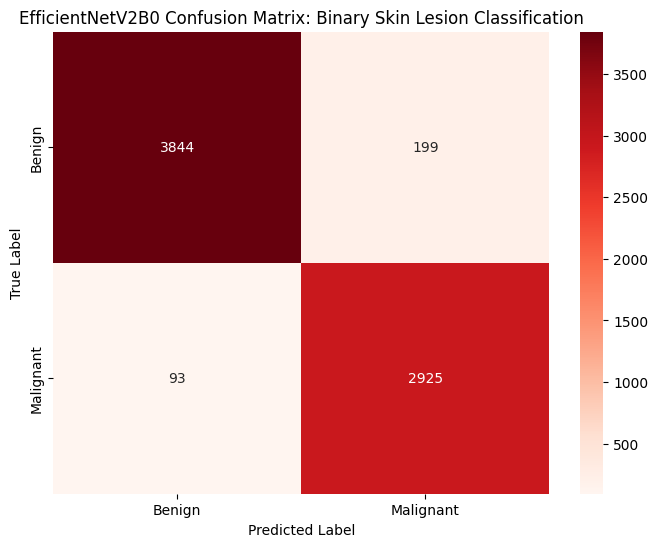

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# true negative   false positive
# false negative  true positive
cm = np.array([
    [3844, 199],
    [93, 2925]
])

ylabels = ['Benign', 'Malignant']
xlabels = ['Benign', 'Malignant']

plt.figure(figsize = (8, 6))
sns.heatmap(
    cm,
    annot = True,
    fmt = 'd',
    cmap = 'Reds',
    xticklabels = xlabels,
    yticklabels = ylabels
)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('EfficientNetV2B0 Confusion Matrix: Binary Skin Lesion Classification')
plt.show()